In [1]:
!pip install tensorflow-io

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 11.4 MB/s eta 0:00:00


In [2]:
# importing the dependencies

import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [3]:
# connecting the colab with the drive to import the data

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# using the zipfile module to extract the data
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/Audio_Classification_Data/Data.zip') as z:
    z.extractall()

In [6]:
def load_wav_16k_mono(filename):

  # reading the contents of the file
  file_contents = tf.io.read_file(filename)

  # decoding the audio file and setting the desired_channels as 1(this will give the mono-audio)
  wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels = 1)

  # using squeeze to make the wav in 1 dimension
  wav = tf.squeeze(wav, axis = -1)

  # changing the datatype to integer
  sample_rate = tf.cast(sample_rate, dtype = tf.int64)

  # changing the wavelength of the data from 48000 to 16000
  wav = tfio.audio.resample(wav, rate_in = sample_rate, rate_out = 16000)
  return  wav

In [5]:
# loading the function load_wav_16k_mono into 2 examples
CAPUCHIN_FILE = os.path.join('Data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('Data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

# calling on example from each classes
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

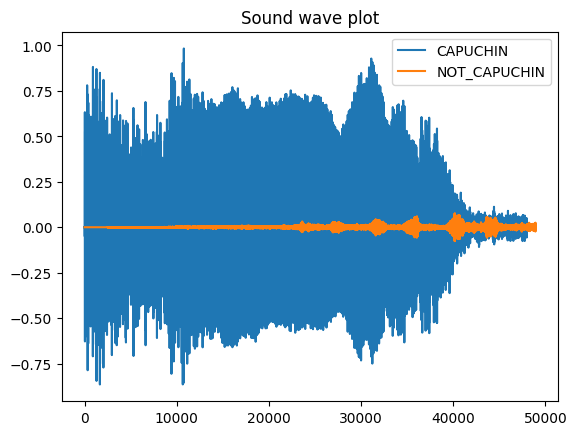

In [8]:
# plotting the soundwave
plt.plot(wave, label = "CAPUCHIN")
plt.plot(nwave, label = "NOT_CAPUCHIN")
plt.title("Sound wave plot")
plt.legend()
plt.show()

# Creating the TensorFlow dataset



In [9]:
# defiining the paths to positive and negative data
POS = os.path.join("Data", "Parsed_Capuchinbird_Clips")
NEG = os.path.join("Data", "Parsed_Not_Capuchinbird_Clips")

In [10]:
# listing all the files of '.wav' format into their respective features.
pos = tf.data.Dataset.list_files(POS+"/*.wav")
neg = tf.data.Dataset.list_files(NEG+"/*.wav")

In [11]:
# adding the labels
"""
1 : if the data is from Parsed_Capuchinbird
0 : if the data is from Parsed_Not_Capuchinbird
"""
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))

# concating both positive and negative data
data = positives.concatenate(negatives)

# Determing the average length of a Capuchin Bird call

In [12]:
# recording the lengths of all the files
lengths = []
for file in os.listdir(os.path.join("Data", "Parsed_Capuchinbird_Clips")):
  tensor_wave = load_wav_16k_mono(os.path.join("Data", "Parsed_Capuchinbird_Clips", file))
  lengths.append(len(tensor_wave))

In [13]:
print(f"Average wavelength of the data is {tf.math.reduce_mean(lengths)}")

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [14]:
print(f"Maxmium wavelength of the file in data is {tf.math.reduce_max(lengths)}")

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [15]:
print(f"Minimum wavelength of the file in data is {tf.math.reduce_min(lengths)}")

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

Preprocessing the whole data set

In [16]:
def preprocess(file_path, label):

  # converting the files into the suitable wavelength
  wav = load_wav_16k_mono(file_path)

  # taking the first 3 secs data
  wav = wav[:48000]

  # applying pre-padding if the data is less than the required 3 sec
  zero_padding = tf.zeros([48000] - tf.shape(wav), dtype = tf.float32)
  wav = tf.concat([zero_padding, wav], 0)

  # creating a spectogram
  spectogram = tf.signal.stft(wav, frame_length = 320, frame_step = 32)

  # converting all the negative values into positive values
  spectogram = tf.abs(spectogram)

  """
  adding a extra dimension in the last of the 2 dimensional data, so that we can use
  convolutional layers
  """
  spectogram = tf.expand_dims(spectogram, axis = 2)
  return spectogram, label

In [17]:
# testing the function on a single example

filepath, label = positives.shuffle(10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)

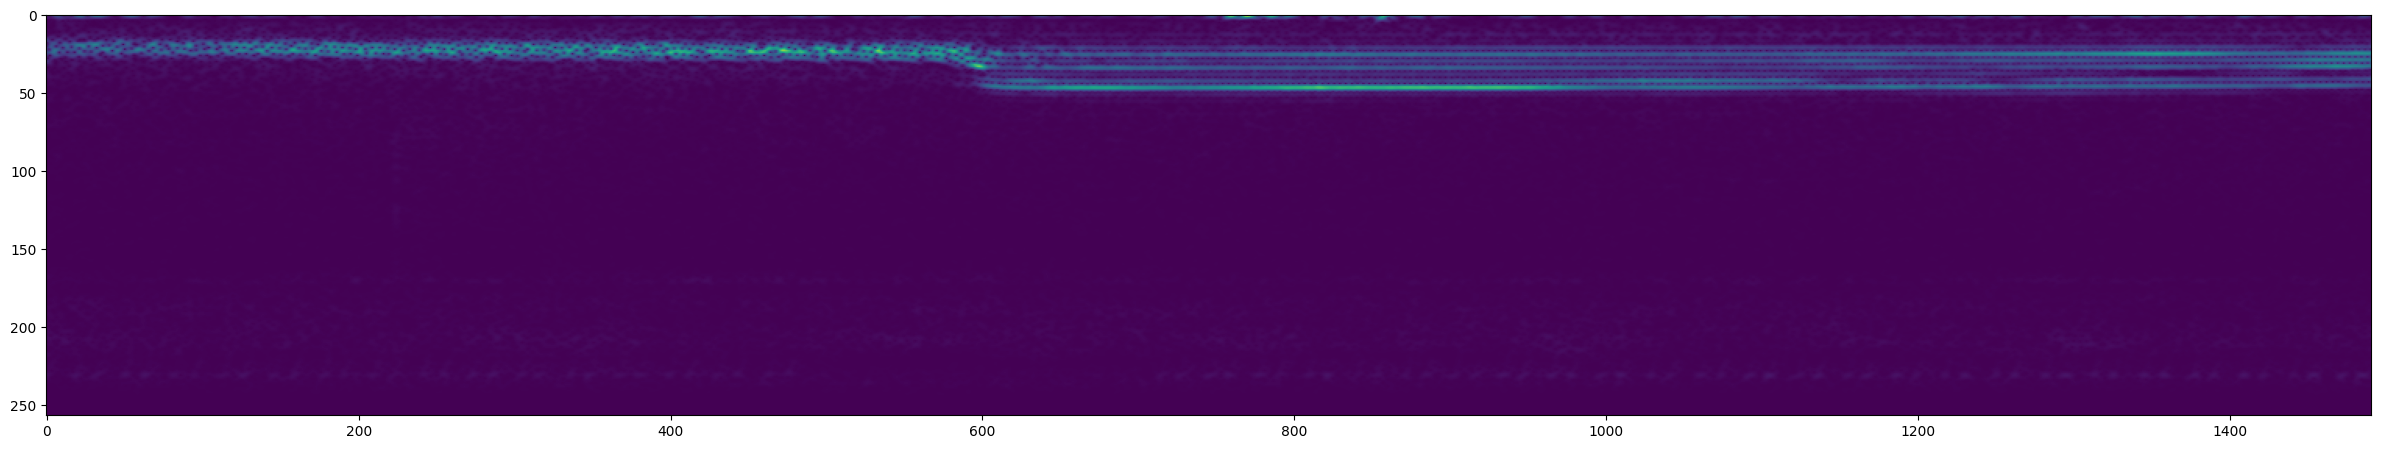

In [19]:
# plotting the wave
plt.figure(figsize = (30, 20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.title("Sample Testing")
plt.show()

# Creating a TensorFlow pipeline

In [20]:
# applying the preprocess function on the whole dataset
data = data.map(preprocess)

# caching the data
data = data.cache()

# applying the shuffle
data = data.shuffle(buffer_size = 1000)

# making batches of 16
data = data.batch(16)
data = data.prefetch(8)

In [21]:
print(f"Length of the whole dataset after applying the batch is {len(data)}")

51

# Splitting the data into train and test dataset

In [22]:
"""
Taking the first 36 examples in the training set
Rest 15 examples are taking in the testing set
"""
train = data.take(36)
test = data.skip(36).take(15)

In [23]:
# taking an example from the training set
samples, labels = train.as_numpy_iterator().next()

In [24]:
print(f"Shape of an example from the training dataset {samples.shape}")

(16, 1491, 257, 1)

Building the TensorFlow Model

In [25]:
# importing the additional dependencies for DL model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense

In [26]:
# initializing the Sequential API
model = Sequential([])

# first CNN layer with maxpooling
model.add(Conv2D(16, (3, 3), activation = "relu", input_shape = (1491, 257, 1)))
model.add(MaxPool2D(2, 2))

# second CNN layer with maxpooling
model.add(Conv2D(16, (2, 2), activation = "relu"))
model.add(MaxPool2D(2, 2))

# flattening the tensor
model.add(Flatten())

# fully connected layer
model.add(Dense(128))

# using the Dropout layer with the probability of 0.2
model.add(Dropout(0.2))

# last layer with single neuron and activation set as "sigmoid"
model.add(Dense(1, activation = "sigmoid"))

In [27]:
# compiling the model with Adam optimizer
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = [tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 744, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 743, 126, 16)      1040      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 371, 63, 16)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 373968)            0         
                                                                 
 dense (Dense)               (None, 128)               4

In [29]:
# trainig the model on 4 epochs
hist = model.fit(train,
                 epochs = 4,
                 validation_data = test)

Epoch 1/4
36/36 [==============================] - 11s 110ms/step - loss: 3.0428 - recall: 0.8658 - precision: 0.7963 - val_loss: 0.1731 - val_recall: 0.9545 - val_precision: 0.9265
Epoch 2/4
36/36 [==============================] - 3s 80ms/step - loss: 0.0532 - recall: 0.9801 - precision: 0.9673 - val_loss: 0.0203 - val_recall: 1.0000 - val_precision: 0.9859
Epoch 3/4
36/36 [==============================] - 3s 87ms/step - loss: 0.0077 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0018 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 3s 83ms/step - loss: 0.0035 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0020 - val_recall: 1.0000 - val_precision: 1.0000


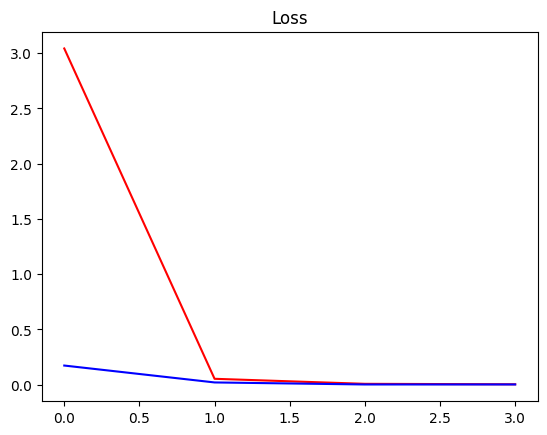

In [30]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r', label = "Training Loss")
plt.plot(hist.history['val_loss'], 'b', label = "Validation Loss")
plt.legend()
plt.show()

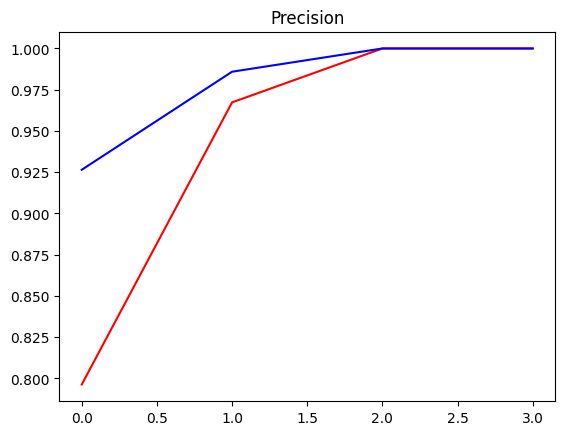

In [31]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r', label = "Training Precision")
plt.plot(hist.history['val_precision'], 'b', label = "Validation Precision")
plt.show()